In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline

# Retina display
%config InlineBackend.figure_format = 'retina'

In [2]:
from tueplots import bundles
plt.rcParams.update(bundles.beamer_moml())


# Also add despine to the bundle using rcParams
plt.rcParams['axes.spines.right'] = False
plt.rcParams['axes.spines.top'] = False

# Increase font size to match Beamer template
plt.rcParams['font.size'] = 16
# Make background transparent
plt.rcParams['figure.facecolor'] = 'none'


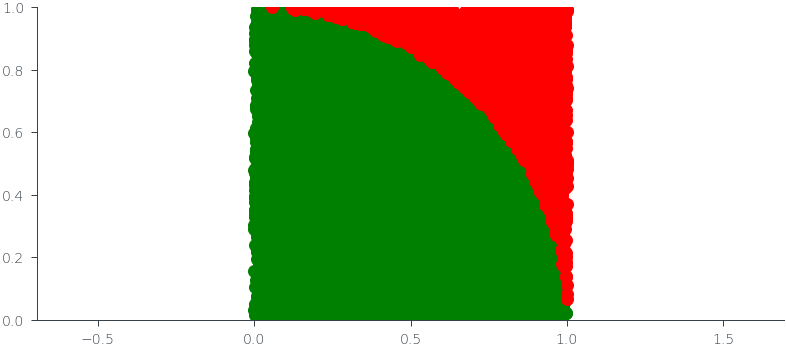

In [5]:
# Monte Carlo simulation for value of pi

def mc_pi(n):
    x = torch.rand(n)
    y = torch.rand(n)
    f = x**2 + y**2 < 1
    ratios = f.float() * 4
    return x, y, f, ratios

def mc_pi_plot(n):
    x, y, f, ratios = mc_pi(n)
    #plt.figure(figsize=(5,5))
    # Green points are inside the circle, red points are outside
    plt.scatter(x[f], y[f], color='g')
    plt.scatter(x[~f], y[~f], color='r')
    plt.axis('equal')
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show()

mc_pi_plot(10000)

In [6]:
# Show the value of pi as a function of the number of points

n = 10000
x, y, f, ratios = mc_pi(n)


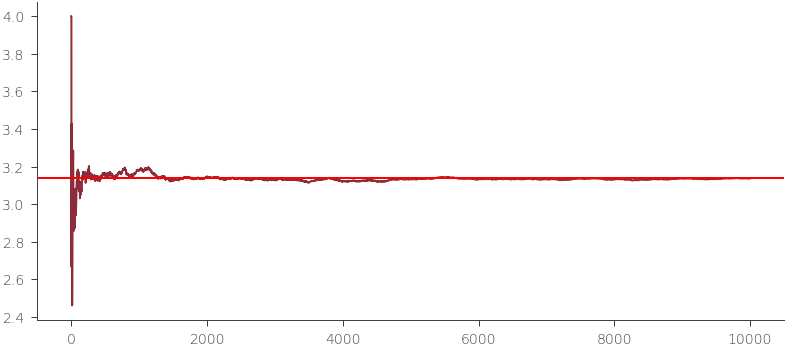

In [7]:
# cumulative sum of ratios
pis = ratios.cumsum(0)/torch.arange(1, n+1)
plt.plot(pis)
plt.axhline(np.pi, color='r')

In [8]:
torch.std(pis, dim=0)

tensor(0.0252)

In [9]:
pis.shape

torch.Size([10000])

In [10]:
pis.shape

torch.Size([10000])

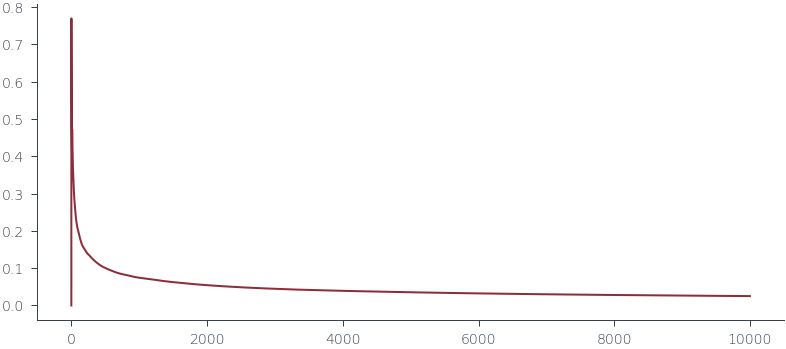

In [11]:
stds = []
for i in range(1, n+1):
    stds.append(pis[:i].std())
plt.plot(stds)


### Gaussian Integral

\begin{equation}
I = \int_{-\infty}^{\infty} e^{-\frac{x^2}{2}} dx
\end{equation}

Normal distribution:
\begin{equation}
f(x) = \frac{1}{\sqrt{2\pi\sigma^2}} e^{-\frac{(x-\mu)^2}{2\sigma^2}}
\end{equation}

For $\mu=0$ and $\sigma=1$:
\begin{equation}
f(x) = \frac{1}{\sqrt{2\pi}} e^{-\frac{x^2}{2}}
\end{equation}

In [12]:
## Rejection sampling

import torch.distributions as D

mix = D.Categorical(torch.ones(2,))
comp = D.Normal(torch.tensor([-0.5, 1.0]), torch.tensor([0.3, 0.5]))
mog = D.MixtureSameFamily(mix, comp)


In [13]:
comp.scale

tensor([0.3000, 0.5000])

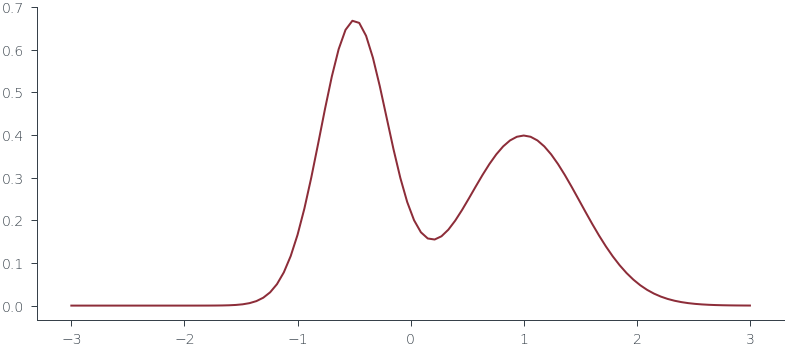

In [14]:
# Plot the mizxture of Gaussians
xs = torch.linspace(-3, 3, 100)
plt.plot(xs, mog.log_prob(xs).exp())

In [15]:
# Take a proposal distribution q(x) = N(0, 1)
q = D.Normal(0, 1)

In [16]:
# Let $M$ be a constant such that $M \geq \frac{p(x)}{q(x)} \forall x$.

M = torch.max(mog.log_prob(xs) - q.log_prob(xs)).exp()
M

tensor(1.9451)

In [17]:
torch.argmax(mog.log_prob(xs) - q.log_prob(xs))

tensor(72)

In [18]:
xs[31]

tensor(-1.1212)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


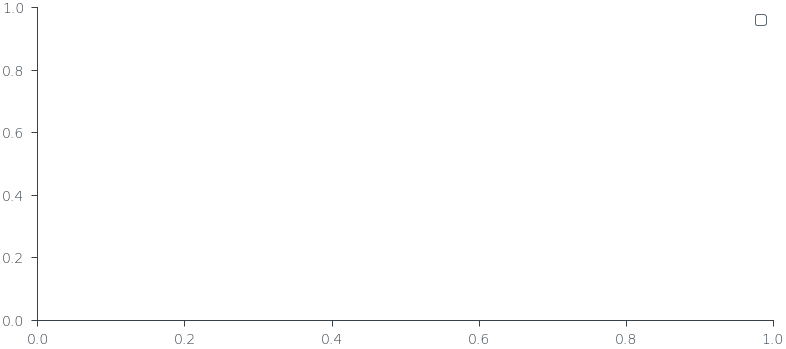

In [23]:
def plot_base():
    # Plot the mixture of Gaussians
    
    plt.legend()
plot_base()

In [51]:
# Sample from the proposal distribution and accept or reject.
# Accepted shown in green, rejected shown in red.

def plot_sample(x, show_q = False, show_Mq = False, show_sample=False, show_vline = False,
                  show_px=False, show_Mqx=False, show_uMqx=False, show_accept=False):
    xs = torch.linspace(-3, 3, 100)
    plt.plot(xs, mog.log_prob(xs).exp(), label='p(x)', color='C0')
    plt.title("Target distribution p(x)")

    if show_q:
        # Plot the proposal distribution
        plt.plot(xs, q.log_prob(xs).exp(), label='q(x)', color='C1')
        plt.title("Proposal distribution q(x)")

    if show_Mq:
        # Plot the scaled proposal distribution
        plt.plot(xs, M * q.log_prob(xs).exp(), label='Mq(x)', color='C2', linestyle='--')
        plt.title("Scaled proposal distribution Mq(x)")
    if show_sample:
        plt.scatter(x, 0,marker='x', color='k', label = r"$x\sim q(x)$")
        plt.title("Sample from proposal distribution")
    
    if show_vline:
        plt.axvline(x, color='C3', linestyle='--')
        plt.title("Sample from proposal distribution")

    if show_px:
        plt.scatter(x, mog.log_prob(x).exp(), color='C4', label=r"$p(x)$")
        plt.title("Evaluate target distribution p(x) at sample x")

    
    if show_Mqx:
        plt.scatter(x, M * q.log_prob(x).exp(), color='k', label=r"$Mq(x)$")
        plt.title("Evaluate scaled proposal distribution Mq(x) at sample x")
    
    if show_uMqx:
        torch.manual_seed(0)
        u = torch.rand(1)
        plt.scatter(x, u * M * q.log_prob(x).exp(), label=r"$uMq(x)$", color='purple')
        plt.title("Draw a uniform u between 0 and 1 and evaluate uMq(x) at sample x")
    
    if show_accept:
        if u * M * q.log_prob(x).exp() < mog.log_prob(x).exp():
            plt.scatter(x, u * M * q.log_prob(x).exp(), label=r"Accepted", color='g')
            plt.title(r"Accept sample as uMq(x) $<$ p(x)")
        else:
            plt.scatter(x, u * M * q.log_prob(x).exp(), label=r"Rejected", color='r')
            plt.title(r"Reject sample as uMq(x) $>$ p(x)")
    
    plt.ylim(-.05, 1.0)
    plt.legend()
    fn  = f"../figures/sampling/rejection-sampling-{x}-{show_q}-{show_Mq}-{show_sample}-{show_vline}-{show_px}-{show_Mqx}-{show_uMqx}-{show_accept}"
    plt.savefig(fn + ".pdf", bbox_inches='tight')
    plt.savefig(fn + ".png", bbox_inches='tight', dpi=600)

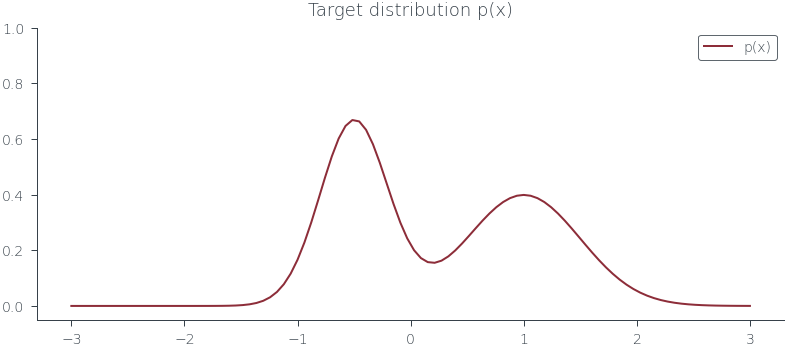

In [52]:
plot_sample(torch.tensor(-1.0))

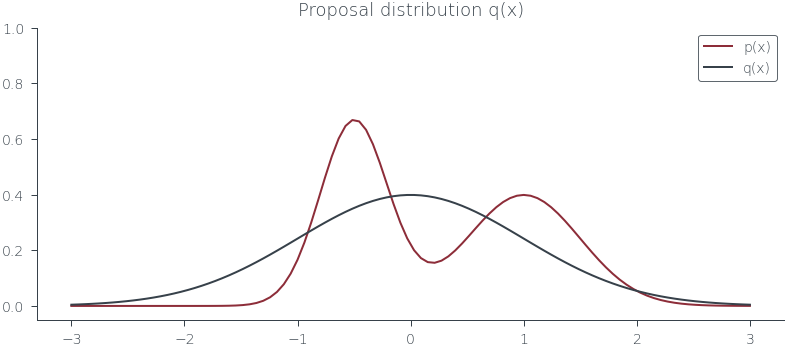

In [53]:
plot_sample(torch.tensor(-1.0), show_q=True)

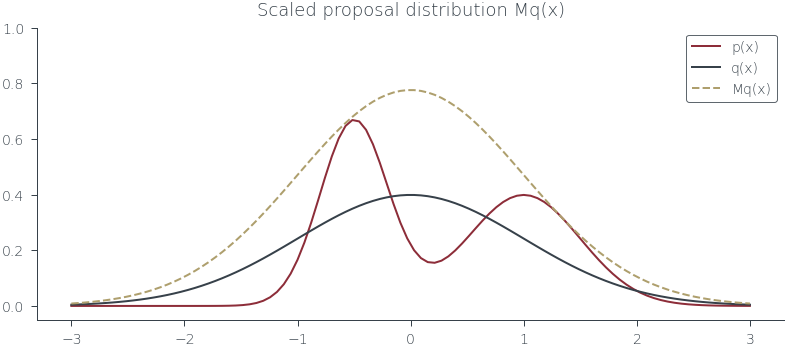

In [54]:
plot_sample(torch.tensor(-1.0), show_q=True, show_Mq=True)

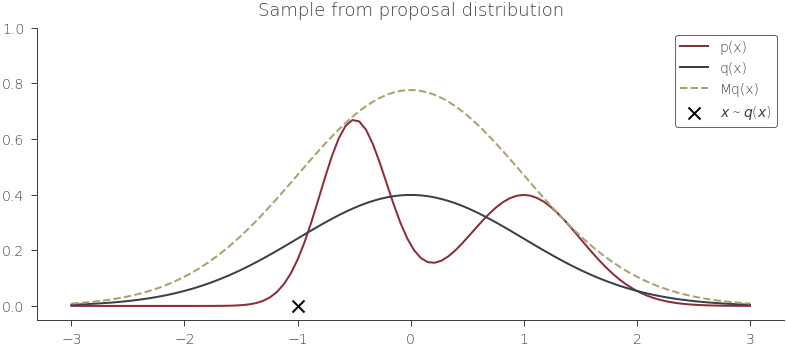

In [55]:
plot_sample(torch.tensor(-1.0), show_q=True, show_Mq=True, show_sample=True)

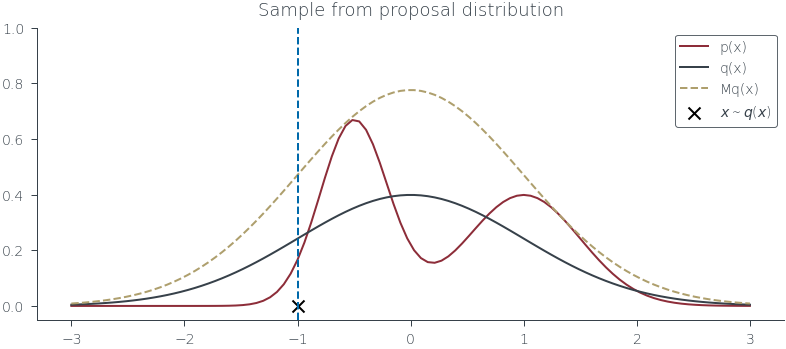

In [56]:
plot_sample(torch.tensor(-1.0), show_q=True, show_Mq=True, show_sample=True, show_vline=True)

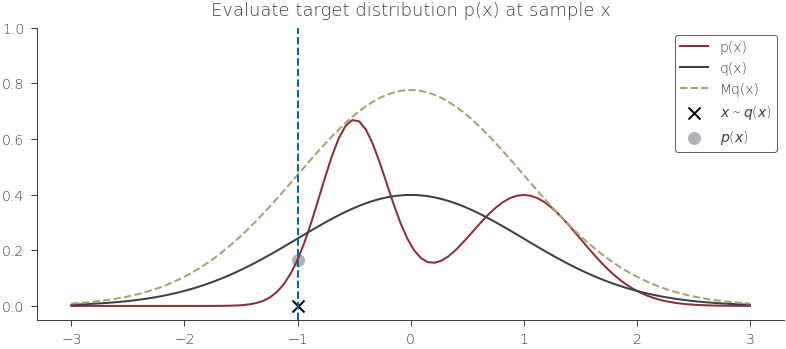

In [57]:
plot_sample(torch.tensor(-1.0), show_q=True, show_Mq=True, show_sample=True, show_vline=True, show_px=True)

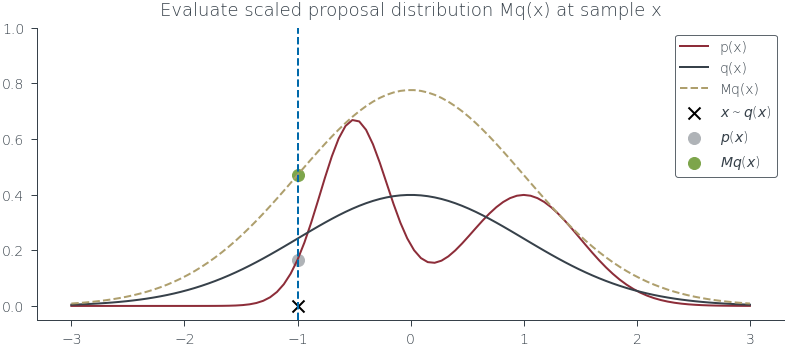

In [58]:
plot_sample(torch.tensor(-1.0), show_q=True, show_Mq=True, show_sample=True, show_vline=True, show_px=True, show_Mqx=True)

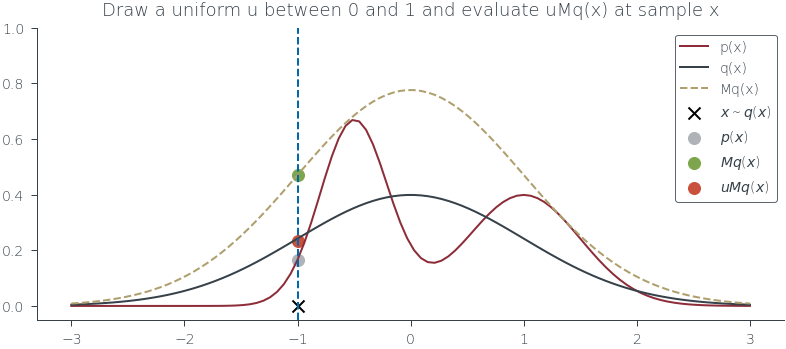

In [59]:
plot_sample(torch.tensor(-1.0), show_q=True, show_Mq=True, show_sample=True, show_vline=True, show_px=True, show_Mqx=True, show_uMqx=True)

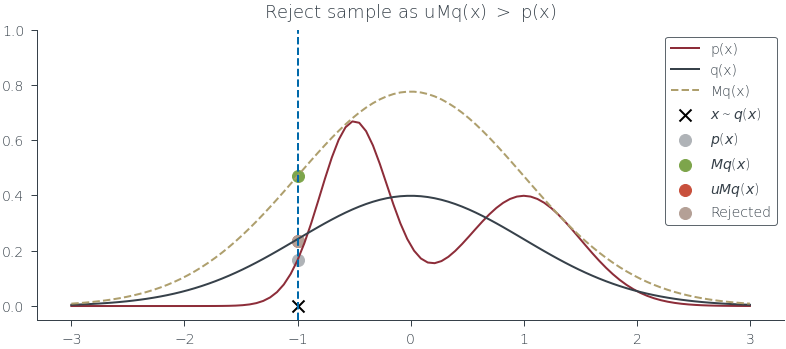

In [60]:
plot_sample(torch.tensor(-1.0), show_q=True, show_Mq=True, show_sample=True, show_vline=True, show_px=True, show_Mqx=True, show_uMqx=True, show_accept=True)

In [50]:
# Create an animation out of the .png generated above
import os
import imageio
import glob

images = []
# Get all the pngs in the figures directory
fs = sorted(glob.glob('../figures/sampling/rejection-sampling*.png'))
for filename in fs:
    ist = imageio.imread(filename)
    images.append(ist)
    # Print image size to make sure they are all the same size
    print(ist.shape)

# Save with high resolution
imageio.mimsave('../figures/sampling/rejection-sampling.gif', images, duration=0.6)
# save as mp4
# os.system("ffmpeg -i figures/sampling/rejection-sampling.gif figures/sampling/rejection-sampling.mp4")



/tmp/ipykernel_69700/3473788105.py:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  ist = imageio.imread(filename)


(1456, 3275, 4)
(1456, 3275, 4)
(1456, 3275, 4)
(1456, 3275, 4)
(1456, 3275, 4)
(1456, 3275, 4)
(1456, 3275, 4)
(1456, 3275, 4)
(1456, 3275, 4)


![](../figures/sampling/rejection-sampling.gif)

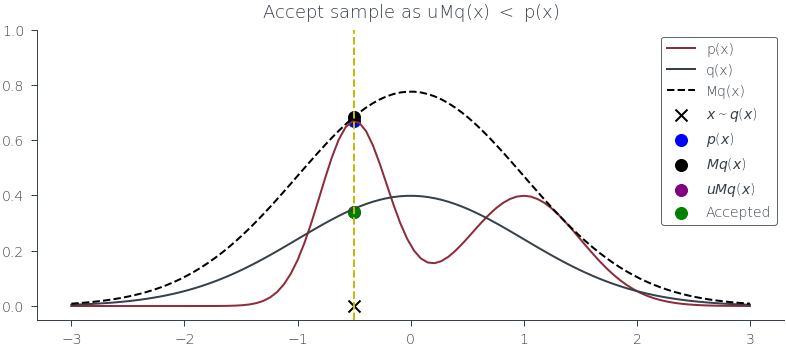

In [49]:
plot_sample(torch.tensor(-0.5), show_q=True, show_Mq=True, show_sample=True, show_vline=True, show_px=True, show_Mqx=True, show_uMqx=True, show_accept=True)

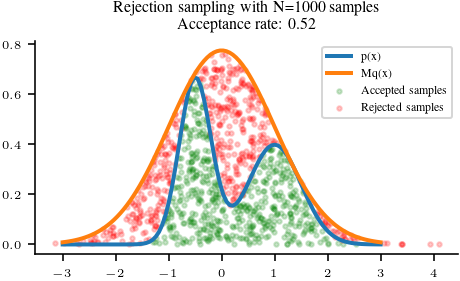

In [113]:
N = 1000

def plot_N_samples(N=100, seed=0, plot_kde=False):
    torch.manual_seed(seed)
    # Now, run the algorithm for a few iterations and plot the results
    samples_from_q = q.sample((N,))

    # Evaluate the target distribution at the samples
    pxs = mog.log_prob(samples_from_q).exp()

    # Evaluate the scaled proposal distribution at the samples
    Mqxs = M * q.log_prob(samples_from_q).exp()

    # Draw a uniform u between 0 and 1
    us = torch.rand(N)

    # Accept or reject the samples
    accepted = us * Mqxs < pxs

    # Plot p, q, and Mq
    plt.plot(xs, mog.log_prob(xs).exp(), label='p(x)', lw=2)
    #plt.plot(xs, q.log_prob(xs).exp(), label='q(x)')
    plt.plot(xs, M * q.log_prob(xs).exp(), label='Mq(x)', lw=2)

    if not plot_kde:

        # Plot the sample as red if it was rejected, and green if it was accepted, height is p(x)
        #plt.scatter(samples_from_q, pxs, color='r', label='Rejected samples')
        plt.scatter(samples_from_q[accepted], (us*Mqxs)[accepted], color='g', label='Accepted samples', alpha=0.2, marker='.', s=20)
        plt.scatter(samples_from_q[~accepted], (us*Mqxs)[~accepted], color='r', label='Rejected samples', alpha=0.2, marker='.', s=20)
        plt.legend()

    if plot_kde:
        import seaborn as sns
        sns.kdeplot(samples_from_q[accepted].numpy(), color='g', label='Density of accepted samples', lw=2)
        plt.legend()
    plt.title(f"Rejection sampling with N={N} samples\n Acceptance rate: {accepted.float().mean().item():.2f}")
    plt.savefig(f"figures/sampling/rejection-sampling-N{N}-{plot_kde}.pdf", bbox_inches='tight')

plot_N_samples(N=1000, seed=0)

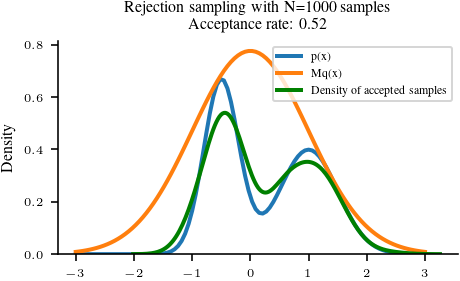

In [114]:
plot_N_samples(N=1000, seed=0, plot_kde=True)

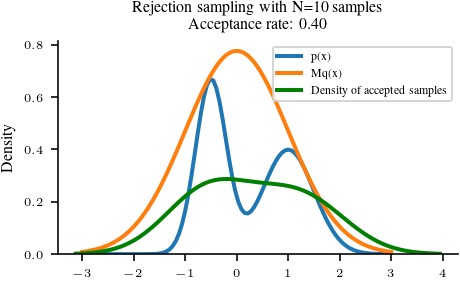

In [118]:
plot_N_samples(N=10, seed=0, plot_kde=True)


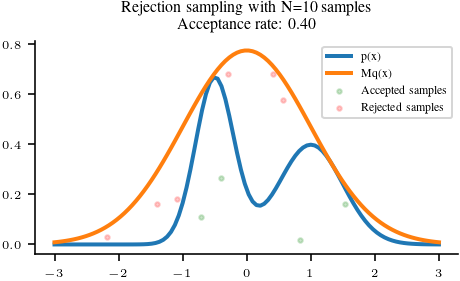

In [119]:
plot_N_samples(N=10, seed=0, plot_kde=False)

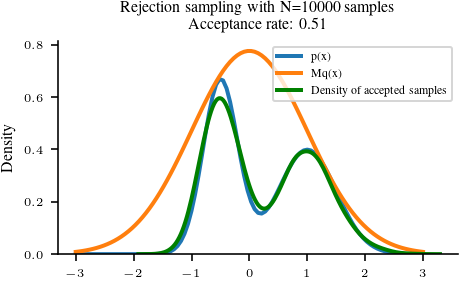

In [116]:
plot_N_samples(N=10000, seed=0, plot_kde=True)

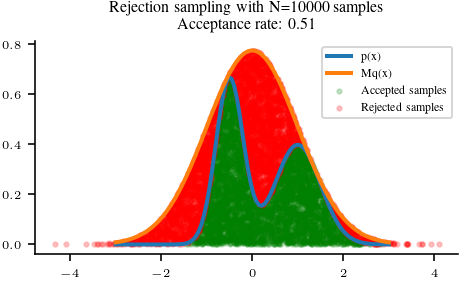

In [120]:
plot_N_samples(N=10000, seed=0, plot_kde=False)